In [118]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Lambda, Dropout, BatchNormalization
from keras import regularizers, losses
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from tensorflow.keras.losses import MeanSquaredError

import os

In [119]:
# Utility functions
def pclip(p):
    """Clip recall probability to avoid numerical issues."""
    return p.clip(0.0001, 0.9999)


def hclip(h):
    min_half_life = 15.0 / (24 * 60)  # 15 minutes in days
    max_half_life = 274.0   
    """Clip half-life to a reasonable range."""
    return h.clip(min_half_life, max_half_life)


In [120]:
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
dff = pd.merge(pd.merge(df_words, df, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')

In [121]:
cols_to_drop = ['lexeme_id' ,'gender', 'def', 'tense', 'POS', 'person', 'number', 'word','avg_user_p_recall', 'timestamp', 'user_id', 
                'learning_language', 'ui_language']
dff.drop(columns=cols_to_drop, inplace=True)
dff.dropna(inplace=True)

# dff.drop(columns=['h_recall'], inplace=True)

In [122]:
# columns transformation
dff['delta'] = dff['delta']/(60*60*24) # convert time delta to days
dff['avg_delta'] = np.sqrt(dff['avg_delta']/(60*60*24)) 
dff['std_delta'] = np.sqrt(dff['std_delta']/(60*60*24)+1e-10)
dff['p_recall'] = pclip(dff['p_recall'])
dff['half_life'] = hclip(-dff['delta']/np.log2(dff['p_recall']))
dff['history_wrong'] = np.log2(1+(dff['history_seen'] - dff['history_correct']))
dff['history_seen'] = np.log2((1+dff['history_seen']))
dff['history_correct'] = np.log2(1+dff['history_correct'])
dff['SUBTLEX'] = np.log2(dff['SUBTLEX'])

In [150]:
dff

,word_len,tags_list,SUBTLEX,p_recall,delta,history_seen,history_correct,session_seen,session_correct,h_recall,lang_combination,avg_delta,std_delta,avg_h_recall,half_life,history_wrong
0,5,"['vblex', 'pri', 'p3', 'sg']",11.72750,0.99990,0.06902,3.16993,2.80735,6,6,0.75000,en-de,0.18955,0.18563,0.89022,274.00000,1.58496
1,5,"['vblex', 'pri', 'p3', 'sg']",11.72750,0.00010,0.00293,3.90689,3.70044,1,0,0.85714,en-de,0.18955,0.18563,0.89022,0.01042,1.58496
2,5,"['vblex', 'pri', 'p3', 'sg']",11.72750,0.99990,0.00075,4.00000,3.70044,1,1,0.80000,en-de,0.18955,0.18563,0.89022,5.21439,2.00000
3,5,"['vblex', 'pri', 'p3', 'sg']",11.72750,0.50000,0.00031,4.08746,3.80735,2,1,0.81250,en-de,0.18955,0.18563,0.89022,0.01042,2.00000
4,5,"['vblex', 'pri', 'p3', 'sg']",11.72750,0.99990,0.00207,4.00000,4.00000,2,2,1.00000,en-de,1.00493,1.27823,0.91407,14.35962,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12509996,7,"['n', 'f']",9.88722,0.99990,0.41822,1.00000,1.00000,1,1,1.00000,en-de,1.65381,2.28905,0.92941,274.00000,0.00000
12509997,9,rare,16.03024,0.99990,4.48485,1.58496,1.00000,1,1,0.50000,en-pt,1.21857,2.33602,0.92893,274.00000,1.00000
12509998,9,rare,16.03024,0.00010,0.07584,2.00000,1.58496,1,0,0.66667,en-pt,1.21857,2.33602,0.92893,0.01042,1.00000
12509999,5,rare,13.65620,0.99990,0.07584,1.58496,1.00000,1,1,0.50000,en-pt,1.21857,2.33602,0.92893,274.00000,1.00000


In [124]:
dff.select_dtypes(include='number').skew()

word_len           0.72083
SUBTLEX            0.13531
p_recall          -2.66131
delta              3.54230
history_seen       0.93116
history_correct    0.92985
session_seen       2.87085
session_correct    2.56061
h_recall          -1.63322
avg_delta          1.29760
std_delta          0.63564
avg_h_recall      -1.71059
half_life         -0.15965
history_wrong      1.38584
dtype: float64

In [125]:
dff.describe().map(lambda x: f"{x:0.3f}")

,word_len,SUBTLEX,p_recall,delta,history_seen,history_correct,session_seen,session_correct,h_recall,avg_delta,std_delta,avg_h_recall,half_life,history_wrong
count,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000,12505498.000
mean,4.745,16.570,0.897,5.424,3.182,3.041,1.814,1.642,0.901,1.974,2.203,0.901,155.476,0.862
std,2.040,3.806,0.270,11.760,1.413,1.408,1.356,1.315,0.136,1.236,1.236,0.048,124.083,1.049
min,1.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.045,0.003,0.000,0.333,0.010,0.000
25%,3.000,13.660,1.000,0.006,2.000,2.000,1.000,1.000,0.833,1.116,1.299,0.880,19.093,0.000
50%,5.000,16.072,1.000,0.841,2.807,2.807,1.000,1.000,0.964,1.712,1.981,0.906,274.000,1.000
75%,6.000,19.622,1.000,4.843,4.000,3.807,2.000,2.000,1.000,2.570,2.982,0.929,274.000,1.585
max,22.000,24.779,1.000,86.448,8.683,8.476,20.000,20.000,1.000,9.290,7.747,1.000,274.000,8.082


In [126]:
# # Encoding tags and langs 
# tag_encoder = LabelEncoder()
# lang_encoder = LabelEncoder()

# dff['tags_list'] = tag_encoder.fit_transform(dff['tags_list'])
# dff['lang_combination'] = lang_encoder.fit_transform(dff['lang_combination'])

In [127]:
def scale_dataset(df):
    categorical_features = df.select_dtypes(include='O').columns
    numeric_features = df.select_dtypes(exclude=['O']).columns.drop(['p_recall', 'half_life', 'delta', 'session_seen', 'session_correct'])

    scaler = MinMaxScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
    return df, categorical_features, numeric_features

In [128]:
def ohe(df):
    """
    One-hot encode categorical variables
    """ 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([df.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded



tag_counts = dff['tags_list'].value_counts()
rare_threshold = 1000
dff['tags_list'] = dff['tags_list'].apply(lambda x: x if tag_counts[x] > rare_threshold else 'rare')

dff.drop(columns=['POS', 'person', 'number', 'gender', 'tense', 'def'], inplace=True, errors='ignore')
dff.dropna(inplace=True)
df_final = dff.sample(frac=1)
df_final = ohe(df_final)
df_final, categorical_features, numeric_features = scale_dataset(df_final)

In [129]:
# Train test split
def split(df, numeric_features): 
    
    X = df.drop(columns=['p_recall', 'half_life'])
    y = df[['p_recall', 'half_life']]
    
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)

    X_test_session = X_test[['session_seen', 'session_correct']]

    
    X_train_delta = X_train['delta'].to_numpy().reshape(-1,1)
    X_test_delta = X_test['delta'].to_numpy().reshape(-1,1)
    
    X_train_numerical = X_train[numeric_features].to_numpy()
    X_test_numerical = X_test[numeric_features].to_numpy()
    
    
    # Embeddings 
    # X_train_tags = X_train['tags_list'].to_numpy().reshape(-1,1)
    # X_train_langs = X_train['lang_combination'].to_numpy().reshape(-1,1)
    # X_test_tags = X_test['tags_list'].to_numpy().reshape(-1,1)
    # X_test_langs = X_test['lang_combination'].to_numpy().reshape(-1,1)
    

    y_train_p_recall = y_train['p_recall']
    y_train_half_life = y_train['half_life']
    y_test_p_recall = y_test['p_recall']
    y_test_half_life = y_test['half_life']

    # Embeddings 
    # return df, X_train_tags, X_train_langs, X_train_numerical, X_test_tags, X_test_langs, X_test_numerical, X_train_delta, X_test_delta, X_test, y_train, y_test, y_train_half_life, y_train_p_recall, y_test_half_life, y_test_p_recall

    # No embeddings 
    return df, X_train_delta, X_test_delta, X_train_numerical, X_test_numerical, y_train_p_recall, y_train_half_life, y_test_p_recall, y_test_half_life, X_test_session

# Embeddings 
# df, X_train_tags, X_train_langs, X_train_numerical, X_test_tags, X_test_langs, X_test_numerical, X_train_delta, X_test_delta, X_test, y_train, y_test, y_train_half_life, y_train_p_recall, y_test_half_life, y_test_p_recall = split(df_final, numeric_features)


# No embeddings
df, X_train_delta, X_test_delta, X_train_numerical, X_test_numerical, y_train_p_recall, y_train_half_life, y_test_p_recall, y_test_half_life, X_test_session = split(df_final, numeric_features)

In [130]:
# print('X_train_tags_size', X_train_tags.shape)
# print('X_train_langs_size', X_train_langs.shape)
# print('X_train_numerical_size', X_train_numerical.shape)
# print('X_test_tags_size', X_test_tags.shape)
# print('X_test_langs_size', X_test_langs.shape)
# print('X_test_numerical_size', X_test_numerical.shape)
# print('y_train_half_life_size', y_train_half_life.shape)
# print('y_train_p_recall_size', y_train_p_recall.shape)
# print('y_test_half_life_size', y_test_half_life.size)
# print('y_test_p_recall_size', y_test_p_recall.size)

In [131]:
def compute_custom_weights(y, num_bins = 5): 
    bins = np.quantile(y, np.linspace(0, 1, num_bins + 1))
    bin_indices = np.digitize(y, bins, right=True)
    bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)
    bin_freqs = bin_counts / len(y)

    # Assign inverse weights
    bin_weights = 1 / (bin_freqs + 1e-6) 
    sample_weights = bin_weights[bin_indices]
    return sample_weights

sample_weights = compute_custom_weights(y_train_p_recall)

In [132]:
# Embeddings
# def emb_layers(df): 
#     len_tags = len(np.unique(df['tags_list']))
#     len_langs = len(np.unique(df['lang_combination']))
    
#     embedding_tags_size = int(min(np.ceil((len_tags)/2), 50))
#     embedding_langs_size = int(min(np.ceil((len_langs)/2), 50))
    
#     tags_input = Input(shape=(1,))  
#     langs_input = Input(shape=(1,))  
    
#     tags_embedded = Embedding(input_dim=len_tags, output_dim=embedding_tags_size)(tags_input)  
#     langs_embedded = Embedding(input_dim=len_langs, output_dim=embedding_langs_size)(langs_input)  
    
#     flattened_tags = Flatten()(tags_embedded)
#     flattened_langs = Flatten()(langs_embedded)
    
#     numerical_input = Input(shape=(len(numeric_features),)) 
#     delta_input = Input(shape=(1,))  
    
#     # Concatenate layers
#     conc_layers = [flattened_tags, flattened_langs, numerical_input]
#     conc = Concatenate()(conc_layers)
#     return conc, numerical_input, delta_input, tags_input, langs_input

# conc, numerical_input, delta_input, tags_input, langs_input = emb_layers(df)



# No embeddings
numerical_input = Input(shape=(len(numeric_features),)) 
delta_input = Input(shape=(1,))

In [133]:
def nhlr_loss(y_true, y_pred):
    h_true, p_true = y_true[0], y_true[1]
    h_pred, p_pred = y_pred[0], y_pred[1]

    slh = tf.reduce_mean(tf.square(h_true - h_pred)) # half-life loss 
    slp = tf.reduce_mean(tf.square(p_true - p_pred)) # p_recall loss 

    return slp + slh 

In [192]:
# Neural Network Architectture
hidden_dim = 16
l2wt = 0.1            
learning_rate = 0.001
epochs = 10
batch_size = 64

# embeddings 
# x = Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(l2wt))(conc)

# no embeddings 
x = Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(l2wt))(numerical_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


# Second layer
# x = Dense(hidden_dim, activation="relu", kernel_regularizer=regularizers.l2(l2wt))(x)

half_life_output = Dense(1, activation="relu", name="half_life")(x) 
p_recall_output = Lambda(lambda inputs: tf.pow(2.0, -inputs[0] / (inputs[1] + 1e-6)), 
                         name="p_recall")([delta_input, half_life_output])


In [193]:
# print("Max tag index:", X_train_tags.max(), "Embedding input_dim:", len_tags)
# print("Max lang index:", X_train_langs.max(), "Embedding input_dim:", len_langs)

# print("Tags Input Shape:", tags_input.shape)
# print("Langs Input Shape:", langs_input.shape)
# print("Numerical Input Shape:", numerical_input.shape)

# print("Flattened tags Embedded Shape:", flattened_tags.shape)
# print("Flattened Langs Embedded Shape:", flattened_langs.shape)
# # print("Flattened Numerical Input Shape:", numerical_input.shape)

# print("X_train_tags shape:", X_train_tags.shape)    
# print("X_train_langs shape:", X_train_langs.shape)  
print("X_train_numerical shape:", X_train_numerical.shape)  
print("X_train_delta shape:", X_train_delta.shape)  
print('X_test numerical shape:', X_test_numerical.shape)  # Expected: (num_samples, 178), but you have (num_samples, 176)
print('X_test delta shape:', X_test_delta.shape)   # Ensure it matches the expected shape
print('input df shape', df_final.shape)

print(y_train_half_life.shape)
print(y_train_p_recall.shape)


X_train_numerical shape: (10000798, 176)
X_train_delta shape: (10000798, 1)
X_test numerical shape: (2500200, 176)
X_test delta shape: (2500200, 1)
input df shape (12500998, 181)
(10000798,)
(10000798,)


In [194]:
# inputs_list = [tags_input, langs_input, numerical_input, delta_input]
# X_train_list = [X_train_tags, X_train_langs, X_train_numerical, X_train_delta]

model = Model(inputs=[numerical_input, delta_input], outputs=[half_life_output, p_recall_output])

model.compile(loss=nhlr_loss, optimizer= Adam(learning_rate=learning_rate), metrics=['MAE', 'MAE'])
model.fit([X_train_numerical, X_train_delta], [y_train_half_life, y_train_p_recall], epochs=epochs, batch_size=batch_size, verbose=2)
model.summary()

Epoch 1/10
156263/156263 - 54s - 345us/step - half_life_MAE: 115.3542 - half_life_loss: 31835.3457 - loss: 31850.3145 - p_recall_MAE: 0.1206 - p_recall_loss: 0.1674
Epoch 2/10
156263/156263 - 53s - 342us/step - half_life_MAE: 113.4768 - half_life_loss: 30468.6211 - loss: 30497.5156 - p_recall_MAE: 0.1173 - p_recall_loss: 0.1608
Epoch 3/10
156263/156263 - 54s - 343us/step - half_life_MAE: 112.9148 - half_life_loss: 29876.4277 - loss: 29920.4844 - p_recall_MAE: 0.1170 - p_recall_loss: 0.1602
Epoch 4/10
156263/156263 - 54s - 343us/step - half_life_MAE: 112.7424 - half_life_loss: 29638.3730 - loss: 29699.0039 - p_recall_MAE: 0.1169 - p_recall_loss: 0.1600
Epoch 5/10
156263/156263 - 53s - 342us/step - half_life_MAE: 112.6110 - half_life_loss: 29425.4238 - loss: 29503.4414 - p_recall_MAE: 0.1168 - p_recall_loss: 0.1618
Epoch 6/10
156263/156263 - 54s - 343us/step - half_life_MAE: 112.4496 - half_life_loss: 29167.7344 - loss: 29261.5957 - p_recall_MAE: 0.1167 - p_recall_loss: 0.1626
Epoch 7/10

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 176)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │      2,832 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 16)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ half_life (Dense)   │ (None, 1)         │         17 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_recall (Lambda)   │ (None, 1)         │          0 │ input_layer_9[0]… │
│                     │                   │            │ half_life[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,677 (33.90 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 5,764 (22.52 KB)

In [195]:
# Predict

# Emb
# y_pred_half_life, y_pred_p_recall  = model.predict([X_test_tags, X_test_langs, X_test_numerical, X_test_delta])


# No emb 
y_pred_half_life, y_pred_p_recall  = model.predict([X_test_numerical, X_test_delta])


78132/78132 ━━━━━━━━━━━━━━━━━━━━ 16s 207us/step


In [196]:
print('Test MAE:', mean_absolute_error(y_test_p_recall, y_pred_p_recall))

Test MAE: 0.11544258326441678


In [197]:
df_results = X_test_session.copy()
df_results['p_recall'] = y_test_p_recall
df_results['p_recall_pred'] = y_pred_p_recall
df_results['diff'] = df_results['p_recall'] - df_results['p_recall_pred']
df_results

,session_seen,session_correct,p_recall,p_recall_pred,diff
1716502,2.00000,2.00000,0.99990,0.99997,-0.00007
3873527,1.00000,1.00000,0.99990,0.99700,0.00290
529291,1.00000,1.00000,0.99990,0.92519,0.07471
7339767,1.00000,1.00000,0.99990,0.99986,0.00004
7749657,1.00000,1.00000,0.99990,0.85560,0.14430
...,...,...,...,...,...
10457387,5.00000,5.00000,0.99990,0.99985,0.00005
1755344,3.00000,3.00000,0.99990,0.99999,-0.00009
11956066,3.00000,3.00000,0.99990,0.99992,-0.00002
10234156,2.00000,1.00000,0.50000,0.99994,-0.49994


In [198]:
df_results.sort_values(by='diff')
df_results

,session_seen,session_correct,p_recall,p_recall_pred,diff
1716502,2.00000,2.00000,0.99990,0.99997,-0.00007
3873527,1.00000,1.00000,0.99990,0.99700,0.00290
529291,1.00000,1.00000,0.99990,0.92519,0.07471
7339767,1.00000,1.00000,0.99990,0.99986,0.00004
7749657,1.00000,1.00000,0.99990,0.85560,0.14430
...,...,...,...,...,...
10457387,5.00000,5.00000,0.99990,0.99985,0.00005
1755344,3.00000,3.00000,0.99990,0.99999,-0.00009
11956066,3.00000,3.00000,0.99990,0.99992,-0.00002
10234156,2.00000,1.00000,0.50000,0.99994,-0.49994


In [199]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df_results.describe()

,session_seen,session_correct,p_recall,p_recall_pred,diff
count,2500200.00000,2500200.00000,2500200.00000,2500200.00000,2500200.00000
mean,1.81337,1.64202,0.89742,0.97983,-0.08241
std,1.35383,1.31268,0.26958,0.04144,0.27126
min,1.00000,0.00000,0.00010,0.00000,-0.99990
25%,1.00000,1.00000,0.99990,0.98059,-0.00009
50%,1.00000,1.00000,0.99990,0.99633,0.00014
75%,2.00000,2.00000,0.99990,0.99997,0.01357
max,20.00000,20.00000,0.99990,1.00000,0.99990


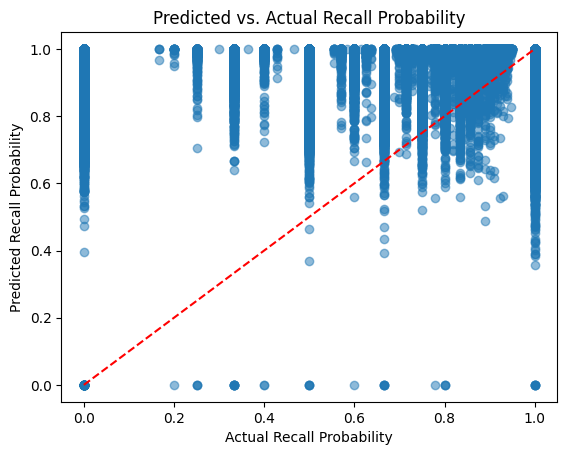

In [211]:
# Predicted vs Actual 
def out_filepath(filename):
    return os.path.normpath(os.path.join(current_dir, '../reports', filename))

    
pred_scatterplot = plt.scatter(df_results['p_recall'], df_results['p_recall_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")
pred_scatterplot.figure.savefig(out_filepath('visualizations/HNN_predictions_scatterplot.png'))


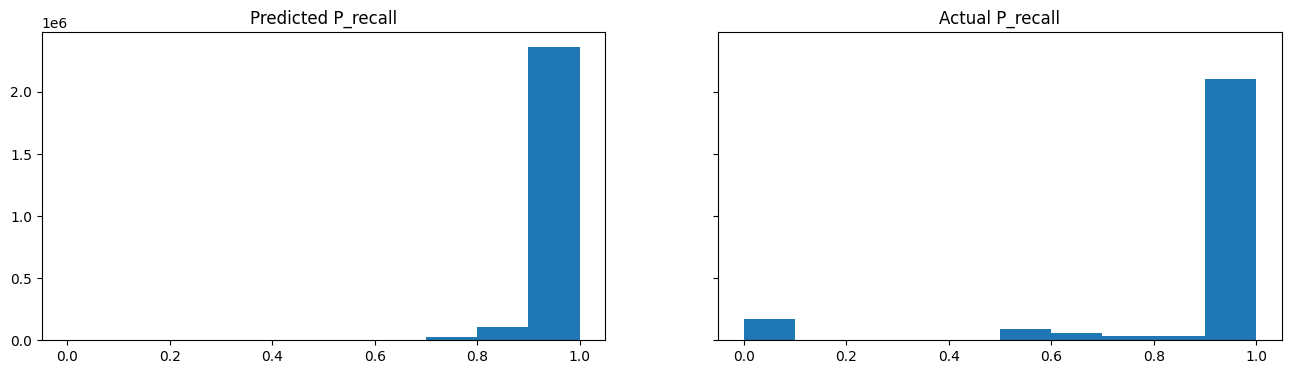

In [201]:
p_recall_histogram, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Predicted P_recall')
ax2.hist(df_results['p_recall'])
ax2.set_title('Actual P_recall')
ax1.hist(df_results['p_recall_pred'])
p_recall_histogram.set_size_inches(16, 4)

In [202]:
expanded_df = df_results.loc[df_results.index.repeat(df_results["session_seen"])].reset_index(drop=True)
expanded_df["outcome"] = np.concatenate([
    np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
    for s, c in zip(df_results["session_seen"], df_results["session_correct"])
])

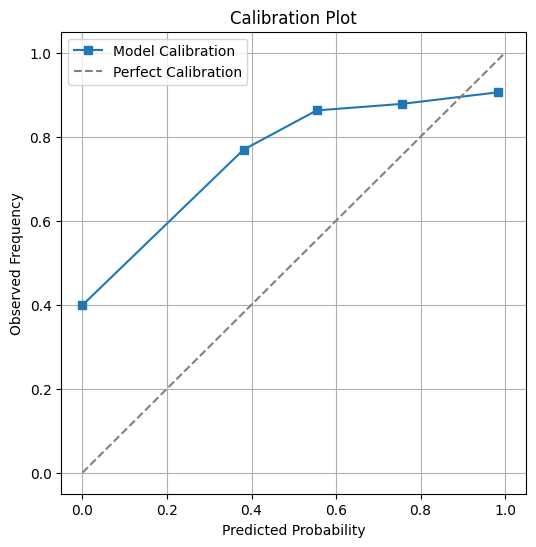

In [203]:
%run diagnostics.ipynb

plot_calibration(expanded_df['outcome'], expanded_df['p_recall_pred'], 'HNN_calibration_plot.png')

AUC Score: 0.5363


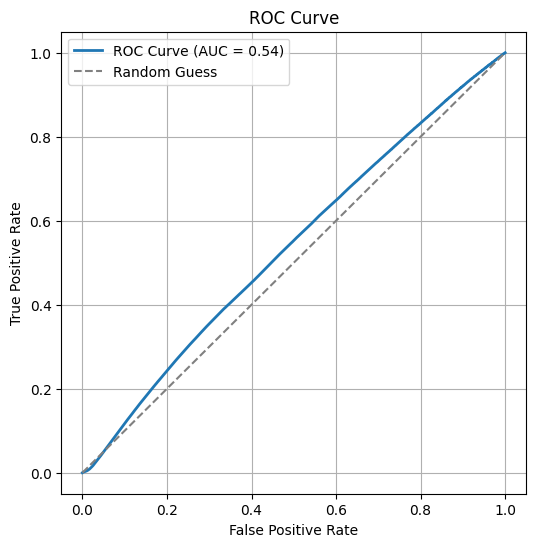

In [204]:
AUC_ROC(expanded_df['outcome'], expanded_df['p_recall_pred'], 'HNN_ROC_plot.png')

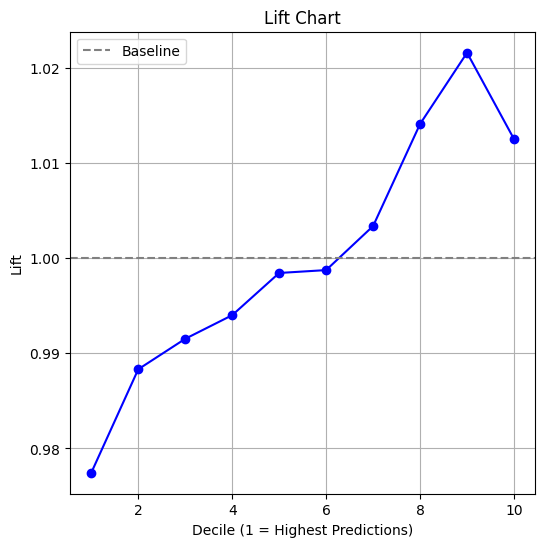

In [205]:
plot_lift(expanded_df, 'HNN_lift_plot.png')